# Adaboost Classifier

In this project, we will implement the Adaboost classifier using decison stumps as its weak classifiers to classify the "iris" dataset.

## Import Packages

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Import Dataset

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['species'] = y
df['species'] = df['species'].map({i: target_names[i] for i in range(len(target_names))})

## EDA

In [3]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
df.shape

(150, 5)

In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# Check for missing data
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

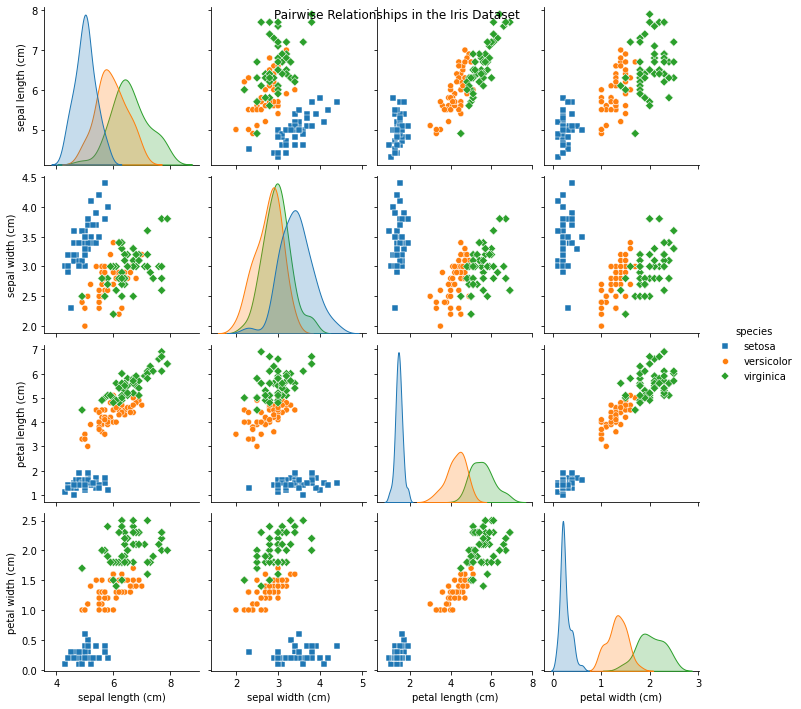

In [7]:
sns.pairplot(df, hue='species', markers=["s", "o", "D"])
plt.suptitle('Pairwise Relationships in the Iris Dataset')
plt.show()

## Preprocessing
Here, we will split the data to training and test sets (70-30).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((105, 4), (45, 4), (105,), (45,))

## Adaboost

In [10]:
class SimpleMultiClassBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learners = []
        self.learner_weights = []
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        # Convert labels to [0, n_classes-1]
        y = self.label_encoder.fit_transform(y)
        n_samples, n_classes = len(y), len(np.unique(y))
        
        # Initialize weights uniformly
        sample_weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            learner = clone(self.base_estimator)
            learner.fit(X, y, sample_weight=sample_weights)
            predictions = learner.predict(X)
            
            # Compute weighted error rate (misclassification rate)
            incorrect = (predictions != y)
            learner_error = np.dot(sample_weights, incorrect) / np.sum(sample_weights)
            
            # Compute learner weight using SAMME algorithm
            learner_weight = np.log((1 - learner_error) / learner_error) + np.log(n_classes - 1)
            
            if learner_error >= 1 - (1 / n_classes):
                break  # Stop if the learner is no better than random guessing
            
            # Increase the weights of misclassified samples
            sample_weights *= np.exp(learner_weight * incorrect)
            sample_weights /= np.sum(sample_weights)
            
            # Save the current learner
            self.learners.append(learner)
            self.learner_weights.append(learner_weight)

    def predict(self, X):
        # Collect predictions from each learner
        learner_predictions = np.array([learner.predict(X) for learner in self.learners])
        
        # Weighted vote for each sample's prediction across all learners
        weighted_votes = np.zeros((X.shape[0], len(self.label_encoder.classes_)))
        for learner_weight, predictions in zip(self.learner_weights, learner_predictions):
            for i, prediction in enumerate(predictions):
                weighted_votes[i, prediction] += learner_weight
        
        # Final prediction is the one with the highest weighted vote
        final_predictions = np.argmax(weighted_votes, axis=1)
        
        # Convert back to original class labels
        return self.label_encoder.inverse_transform(final_predictions)

In [11]:
# Train the model
model = SimpleMultiClassBoosting(n_estimators=50)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0])

In [12]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion_mat)

Accuracy: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
